# Setup

In [1]:
# data processing
import pandas as pd

# topic modelling
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# data visualization
import matplotlib.pyplot as plt

# plot grahps
import seaborn as sns

# word cloud
from wordcloud import WordCloud

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Import

In [2]:
# import cleaned nouns and read as list
speeches = []
with open('output/cleaned_nouns.txt', 'r',encoding="utf-8") as file:
    for word in file:
        speech = word[:-1] 
        speeches.append(speech)

In [3]:
# define a function to tokenize the speeches
def tokenize(words):
    tokens_list = []
    for word in words:
        xin = simple_preprocess(word, deacc = True)
        tokens_list.append(xin)
    return tokens_list

In [4]:
toke_sp = tokenize(speeches)

In [5]:
# create tf-idf
id2word = corpora.Dictionary(toke_sp)
corpus = [id2word.doc2bow(text) for text in toke_sp]

# Topic Modelling

# Decide Optimal Number of Topics

In [6]:
#define a function of topic modeling
def lda_model(n_topics):
    lda = LdaModel(corpus = corpus, id2word = id2word, num_topics = n_topics, 
                                          random_state = 100, update_every = 1, chunksize = 100, 
                                          passes = 10, per_word_topics = True)
    return lda

#define functions to calculate coherence scores
def c_values(model):
    coherence = CoherenceModel(model = model, texts = toke_sp, dictionary = id2word, 
                                        coherence = 'c_v')
    return coherence

def c_trial(start, limit, step):
    coherence_values_list = []
    for n_topics in range(start, limit, step):
        model = lda_model(n_topics)
        coherence = c_values(model)
        coherence_values_list.append(coherence.get_coherence())
    return coherence_values_list

In [7]:
# calculate coherence scores
start = 1; limit = 20; step = 1
coherence_scores = c_trial(start, limit, step)

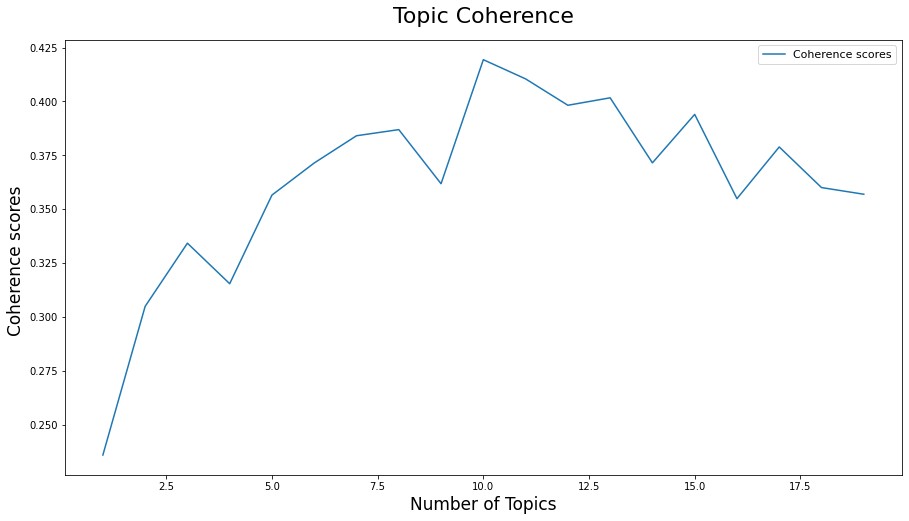

In [8]:
# plot coherence scores
plt.rcParams['figure.figsize'] = [15, 8]
x = range(start, limit, step)
plt.plot(x, coherence_scores, label = "Coherence scores")
plt.xlabel("Number of Topics", fontsize = 17)
plt.ylabel("Coherence scores ", fontsize = 17)
plt.legend(loc = "upper right", fontsize = 11)
plt.title('Topic Coherence', fontsize = 22, pad = 17)
plt.show()

In [9]:
# examine coherence values
for number_topics, cv in zip(x, coherence_scores):
    print(number_topics, 'topics coherence score:', round(cv, 3))

1 topics coherence score: 0.236
2 topics coherence score: 0.305
3 topics coherence score: 0.334
4 topics coherence score: 0.315
5 topics coherence score: 0.357
6 topics coherence score: 0.371
7 topics coherence score: 0.384
8 topics coherence score: 0.387
9 topics coherence score: 0.362
10 topics coherence score: 0.419
11 topics coherence score: 0.41
12 topics coherence score: 0.398
13 topics coherence score: 0.402
14 topics coherence score: 0.372
15 topics coherence score: 0.394
16 topics coherence score: 0.355
17 topics coherence score: 0.379
18 topics coherence score: 0.36
19 topics coherence score: 0.357


# Latent Dirichlet Allocation

In [10]:
# build topic model
number_topics = 8
topic_model_lda = lda_model(number_topics)

# compute perplexity
print('Perplexity: ', round(topic_model_lda.log_perplexity(corpus), 3))

Perplexity:  -7.229


In [11]:
# create data frame of topics with corresponding keywords
lda_topics = [[(term, round(weight, 3)) for term, weight in topic_model_lda.show_topic(n, topn = 20)] 
              for n in range(0, topic_model_lda.num_topics)]
lda_topics_df = pd.DataFrame([', '.join([term for term, weight in topic]) 
                              for topic in lda_topics], columns = ['keywords'],
                             index = ['topic_' + str(t) for t in range(1, topic_model_lda.num_topics + 1)] )

In [12]:
# replace index with topic names
index_names = lda_topics_df.index.values.tolist()
topic_names = ['politics', 'government role', 'war and violence', 'energy and environment', 
               'family', 'health care','international affairs','employment']
lda_topics_df = lda_topics_df.rename(index = dict(zip(index_names, topic_names)))

In [13]:
# print data frame
pd.set_option('display.max_colwidth', 0)
lda_topics_df

,keywords
politics,"president, issue, people, work, country, question, way, state, thing, deal, year, time, lot, election, term, policy, concern, iran, something, part"
government role,"people, country, world, state, nation, work, democracy, change, government, today, time, year, peace, president, leader, help, security, progress, society, opportunity"
war and violence,"force, war, security, nation, year, people, world, time, attack, troop, family, work, state, isil, support, threat, today, country, iraq, effort"
energy and environment,"oil, energy, gas, coast, morehouse, gulf, fuel, spill, disaster, bp, price, car, source, vehicle, drill, hurricane, boom, production, dependence, gallon"
family,"day, year, time, family, life, people, story, work, president, way, today, country, man, woman, help, child, community, heart, america, justice"
health care,"people, care, health, work, law, thing, system, insurance, way, year, time, get, lot, president, problem, state, congress, everybody, something, fact"
international affairs,"india, tennessee, booker, alexander, paula, mumbai, raj, kelsey, eron, vivekananda, byrd, corker, huntsman, kiner, memphis, vishal, swami, neha, diwali, gandhiji"
employment,"job, year, business, work, economy, tax, country, time, help, family, worker, people, company, thing, way, pay, education, college, school, get"


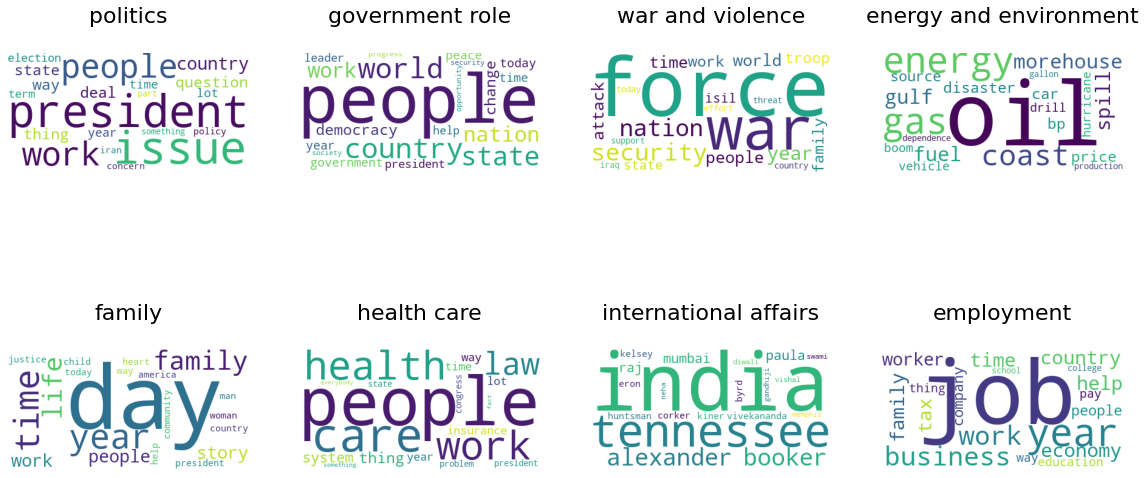

In [14]:
# settings of plot
wc = WordCloud(background_color = "white", max_font_size = 145, random_state = 40)
plt.rcParams['figure.figsize'] = [20, 10]

# create word cloud for each topic
for i in range(topic_model_lda.num_topics):
    wc.generate(text = lda_topics_df["keywords"][i])
    plt.subplot(2, 4, i + 1)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(lda_topics_df.index[i], fontsize = 22, y = 1.2)

In [15]:
##Interactive topic model visualization
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model_lda,corpus,dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.124443  0.061104  1       1        26.773913
7      0.112639 -0.063909  2       1        19.578541
5      0.119639 -0.132555  3       1        13.836490
2      0.075581  0.157332  4       1        13.798290
4      0.049155  0.151534  5       1        13.353522
0      0.147583 -0.126938  6       1        12.044665
3     -0.323674 -0.034288  7       1        0.503265 
6     -0.305367 -0.012279  8       1        0.111313 , topic_info=            Term         Freq        Total Category  logprob  loglift
113   energy      552.000000   552.000000   Default  30.0000  30.0000
280   president   2662.000000  2662.000000  Default  29.0000  29.0000
173   health      1218.000000  1218.000000  Default  28.0000  28.0000
41    care        1276.000000  1276.000000  Default  27.0000  27.0000
199   job         1901.000000  1901.000000  Default  26.0000  26.0000
...   ...                 ...          ...      ...      ...      ...
6392  slack       0.261707     1.090649     Topic8  -7.1490   5.3733 
5656  diwali      0.319804     1.541176     Topic8  -6.9485   5.2280 
5534  catskill    0.202176     1.020307     Topic8  -7.4071   5.1819 
2835  memphis     0.379738     2.187730     Topic8  -6.7768   5.0494 
5751  motorcycle  0.277274     1.865267     Topic8  -7.0912   4.8944 

[581 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
8668  6      0.937679  abadi
3     1      0.085009  act  
3     2      0.246526  act  
3     3      0.367239  act  
3     4      0.168318  act  
...  ..           ...  ...  
428   4      0.137053  year 
428   5      0.141683  year 
428   6      0.098468  year 
3933  4      0.985769  yemen
4198  7      0.498607  از   

[1243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 6, 3, 5, 1, 4, 7])

# Plot Topics Distribution by Years

In [16]:
# create file names to merge data later
name = []
for i in range(len(speeches) ):
               index = "wen_" + str(i + 1)
               name.append(index)
            
# extract topic proportion of topics by speech
topic_proportion_speeches = [topic_model_lda.get_document_topics(item, minimum_probability = 0.0) for item in corpus]
            
# create data frame of Topic proportions by speech
lda_df_proportions = pd.DataFrame.from_records([{v: k for v, k in row} for row in topic_proportion_speeches], 
                                               index = name)
lda_df_proportions.columns = topic_names

In [17]:
## Data process
# import speech content data
df = pd.read_excel("output/obama_speeches_clean.xlsx", index_col = 0)
df.index= name

# merge dates with Topic proportions
df_merge = pd.merge(lda_df_proportions, df, left_index = True, right_index = True)

# remove redundant column
df_merge.drop(df_merge.columns[[9,10,11,12]],axis=1,inplace=True)

#transform format of date
df_merge['date']= pd.to_datetime(df_merge['date'],format= '%d %b %Y')

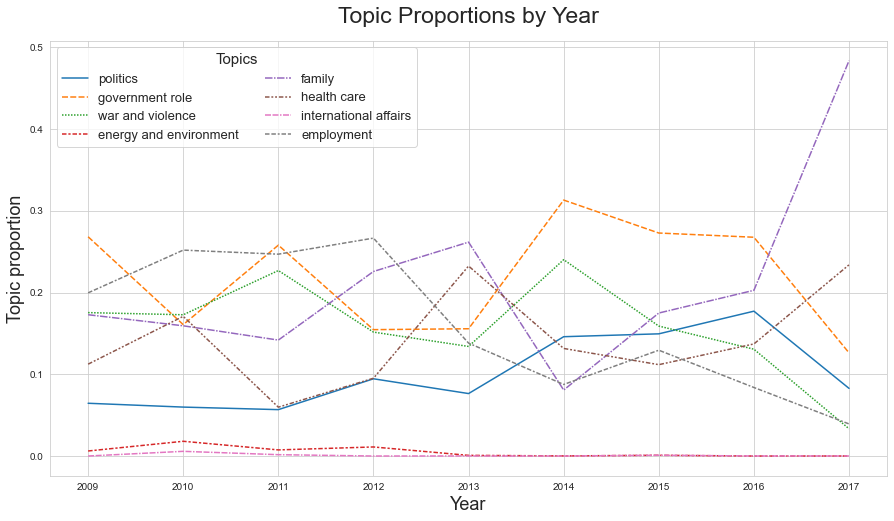

In [18]:
# extract year of speeches
df_merge['year'] = df_merge['date'].dt.year.convert_dtypes()

# average topic proportion per year
topic_proportion_df = df_merge.groupby('year', as_index = False)[topic_names].mean().copy()

# transform data frame from wide to long format
topic_proportion_df_melt = topic_proportion_df.melt(id_vars = 'year', value_vars = topic_names, 
                                                        var_name = 'topic', value_name = 'proportion')

 # plot topic proportion by year
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 8]
topic_proportion = sns.lineplot(data = topic_proportion_df_melt, x = "year", y = "proportion", hue = "topic",style='topic')
topic_proportion.set_xlabel("Year", fontsize = 18)
topic_proportion.set_ylabel("Topic proportion", fontsize = 18)
plt.legend(ncol = 2, loc = 'upper left', fontsize = 13, title = "Topics", title_fontsize = 15, markerscale = 1.5)
plt.title('Topic Proportions by Year', fontsize = 23, pad = 18)
plt.show()

In [19]:
# write data frame to excel file
topic_proportion_df.to_excel("output/topic_distribution.xlsx")